Docs prep....
Vectorize...
Vectorization done
(25000, 200)
(25000, 200)
torch.Size([18750, 2])
Epoch 0 loss 0.693370521068573
Test accuracy 0.496
----------
Epoch 100 loss 0.6345170140266418
Test accuracy 0.664
----------
Epoch 200 loss 0.6148547530174255
Test accuracy 0.680
----------
Epoch 300 loss 0.6060361862182617
Test accuracy 0.688
----------
Epoch 400 loss 0.5924013257026672
Test accuracy 0.693
----------
Epoch 500 loss 0.586024820804596
Test accuracy 0.699
----------
Epoch 600 loss 0.5816061496734619
Test accuracy 0.701
----------
Epoch 700 loss 0.5794112086296082
Test accuracy 0.701
----------
Epoch 800 loss 0.5756969451904297
Test accuracy 0.702
----------
Epoch 900 loss 0.5770707130432129
Test accuracy 0.702
----------


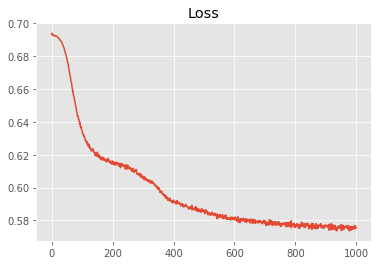

Final Test Acc
Test accuracy 0.701


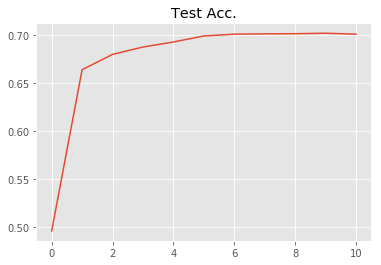

Positive
Positive
Negative
Positive
Positive


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import style
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import os

style.use('ggplot')

POS_TRAIN_PATH = 'datasets/aclImdb/train/pos/'
NEG_TRAIN_PATH = 'datasets//aclImdb/train/neg/'
pos_files = os.listdir(POS_TRAIN_PATH)
neg_files = os.listdir(NEG_TRAIN_PATH)
print('Docs prep....')
pos_lines = []
neg_lines = []
for file in pos_files:
    with open(POS_TRAIN_PATH + file) as f:
        lines = f.readlines()
        lines = [line.strip() for line in lines if line.strip()]
        pos_lines.extend(lines)
for file in neg_files:
    with open(NEG_TRAIN_PATH + file) as f:
        lines = f.readlines()
        lines = [line.strip() for line in lines if line.strip()]
        neg_lines.extend(lines)

docs = []
docs.extend(pos_lines)
docs.extend(neg_lines)
print('Vectorize...')
vectorizer2 = TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS, max_features=200)
vectorizer2.fit(docs)
print('Vectorization done')

input_data2 = vectorizer2.transform(docs).todense()
print(input_data2.shape)
df2 = pd.DataFrame(input_data2)

pos_labels = np.zeros(len(pos_lines))
neg_labels = np.ones(len(neg_lines))

labels2 = []
labels2 = np.append(pos_labels, neg_labels)
df2['labels'] = labels2
# df2.to_csv('data/aclImdb/processed_input_labelled3.csv')

pos_labels = np.zeros(len(pos_lines))
neg_labels = np.ones(len(neg_lines))

X = df2.drop('labels', axis=1)
X = np.array(X)
print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, df2['labels'], random_state=20)
test_accuracies = []
def evaluate(cnn):
    cnn.train(False)
    total = len(X_test)
    correct = 0.0

    for val_x, val_y in zip(X_test, y_test):

        t_x = np.array([[val_x]]).astype(np.float32)

        output = cnn(Variable(torch.from_numpy(np.array(t_x))))

        output = output[0]
        out = output.data.numpy()

        if val_y == 0:

            if not np.argmax(out):
                correct += 1

        if val_y == 1:

            if np.argmax(out):
                correct += 1

    acc = correct / total
    print('Test accuracy %.3f' % (acc))
    test_accuracies.append(acc)


class CNN(nn.Module):
    def __init__(self,output_size):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 1, 3, stride=2)

        self.linear = nn.Linear(49, 10)
        self.linear2 = nn.Linear(10, output_size)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):

        output = F.max_pool1d(self.conv1(x), kernel_size=2)

        output = output.transpose(0,1)
        output = self.dropout(F.relu(self.linear(output[0])))

        output = F.softmax(self.linear2(output))

        return output

cnn = CNN(2)
epochs = 1000
learning_rate = 5e-3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)
losses = []
for epoch in range(epochs):
    cnn.train(True)
    inputs = Variable(torch.from_numpy(np.array([X_train]).astype(np.float32)).transpose(0, 1))
    targets = Variable(torch.from_numpy(np.array(y_train).astype(np.float32)).long())
    optimizer.zero_grad()
    outputs = cnn(inputs)

    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    if epoch == 0:
        print(outputs.size())
    if epoch % 100 == 0:
        
        print('Epoch %d loss %s' % (epoch, loss.data[0]))
        evaluate(cnn)
        print('-'*10)
        
    losses.append(loss.data[0])
plt.title('Loss')
plt.plot(losses)
plt.show()
print('Final Test Acc')
evaluate(cnn)

plt.title('Test Acc.')
plt.plot(test_accuracies)
plt.show()


def test_line(line):
    t_x = vectorizer2.transform([line]).todense().astype(np.float32)

    t_x = np.array([t_x])
    cnn.eval()
    out = cnn(Variable(torch.from_numpy(t_x)))[0]
    val = out.data.numpy()

    
    if not np.argmax(val):
        return 'Positive'
    elif np.argmax(val):
        return 'Negative'
test_neg = """ It was plain boring."""
test_pos = """ The movie was good the actors performed amazingly"""
print(test_line(test_neg))
print(test_line(test_pos))
print(test_line('it was bad '))

print(test_line('I liked it '))

print(test_line('It was good'))
